# Designing a Python API to GraphBLAS and LAGraph

## Michel Pelletier

https://github.com/michelp/pygraphblas

https://github.com/michelp/pggraphblas

In [1]:
print("This is a Jupyter Notebook!")

This is a Jupyter Notebook!


In [2]:
import pygraphblas
print(len(dir(pygraphblas)))

1525


In [3]:
from pygraphblas import *
from pygraphblas.demo.gviz import draw, draw_op, draw_graph, draw_layers

# Matrices from Lists

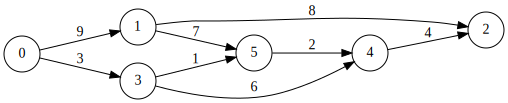

In [4]:
A = Matrix.from_lists(
    [0, 0, 1, 3, 3, 4, 1, 5],
    [1, 3, 2, 4, 5, 2, 5, 4],
    [9, 3, 8, 6, 1, 4, 7, 2],)

draw(A)

# Random Graphs

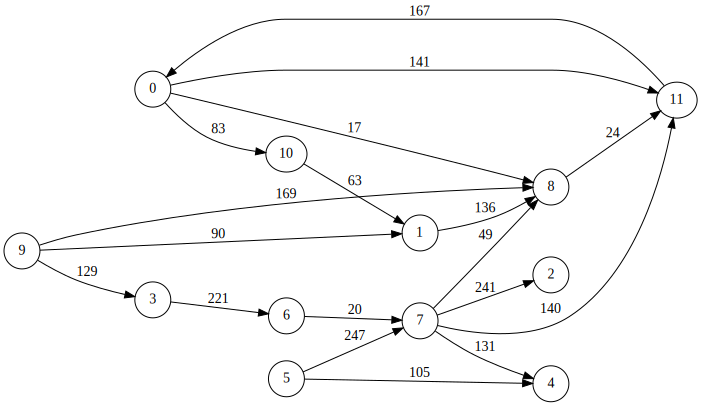

In [5]:
draw(Matrix.from_random(UINT8, 12,12,20, no_diagonal=True, seed=42), show_weight=True)

# Elementwise Addition

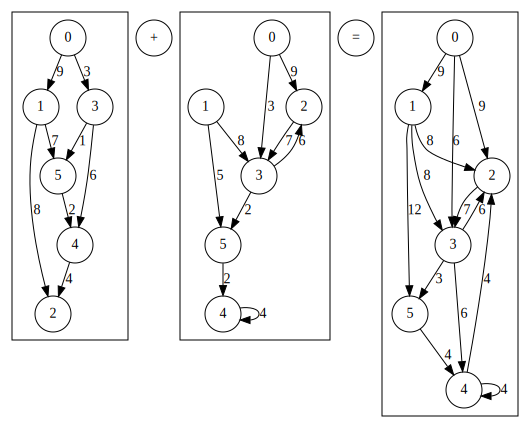

In [6]:
B = Matrix.from_lists(
    [0, 0, 1, 3, 3, 4, 1, 5, 2],
    [2, 3, 3, 2, 5, 4, 5, 4, 3],
    [9, 3, 8, 6, 2, 4, 5, 2, 7],)

C = A + B
draw_op(A, '+', B, C)

# Elementwise Multiplication

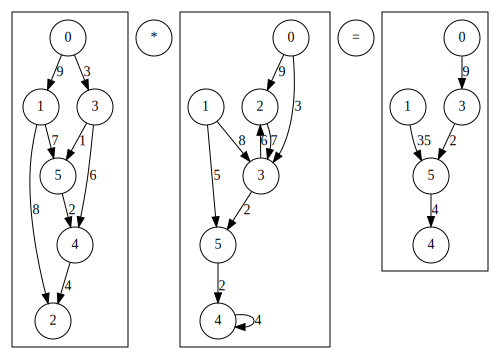

In [7]:
C = A * B
draw_op(A, '*', B, C)

# Using an Operator

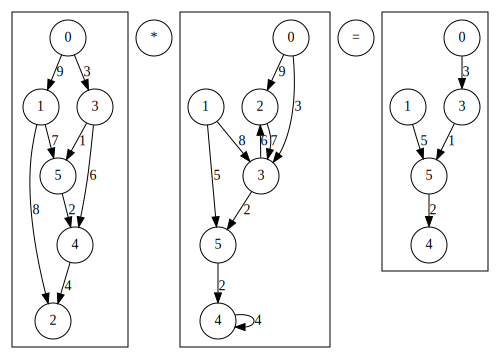

In [8]:
with min:
    C = A * B

draw_op(A, '*', B, C)

# Vector Matrix Multiplication

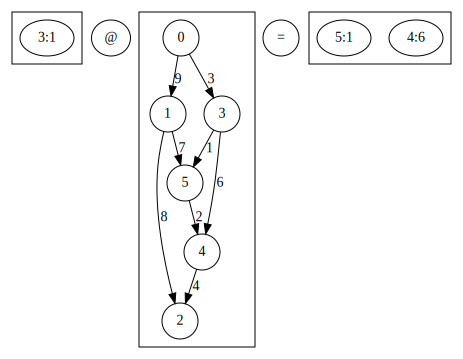

In [9]:
v = Vector.from_lists([3],[1], A.nrows)

y = v @ A
draw_op(v, '@', A, y)

# Matrix Vector Multiplication

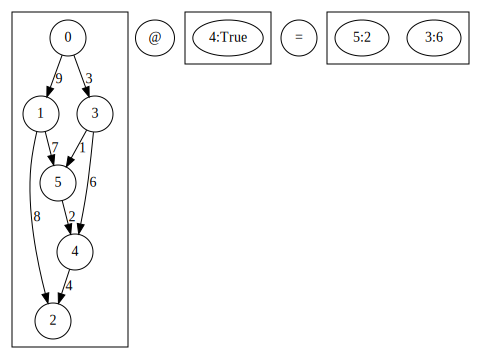

In [10]:
v = Vector.from_lists([4],[True], A.nrows)

y = A @ v
draw_op(A, '@', v, y)

# Matrix Matrix Multiplication

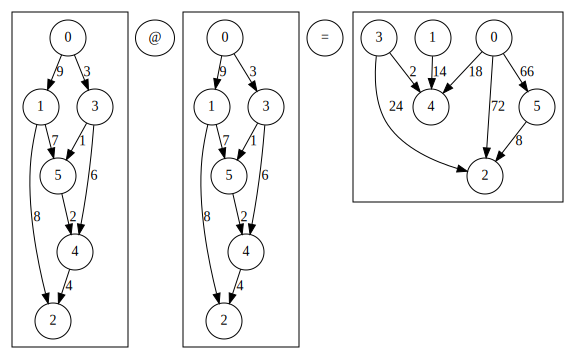

In [11]:
draw_op(A, '@', A, A @ A)

# Using a Semiring

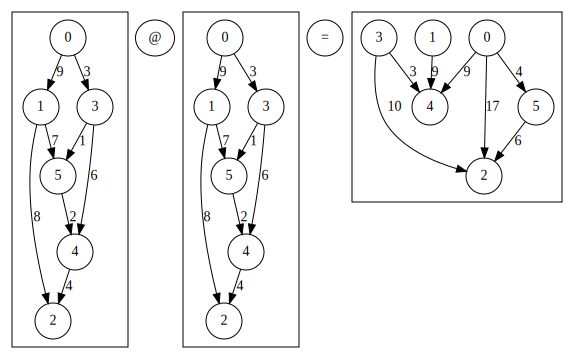

In [12]:
with min_plus:
    g = draw_op(A, '@', A, A @ A)
g

# Breadth First Search

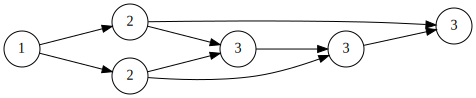

In [13]:
def bfs(matrix, start):
    """Given a graph and a starting position, return a vector of hops to all other nodes."""
    v = Vector.from_type(UINT8, matrix.nrows)   # the result vector
    q = Vector.from_type(BOOL, matrix.nrows)    # a vector to keep track of known nodes
    
    q[start] = True
    not_done = True
    level = 1
    
    while not_done and level <= matrix.nrows:
        v[:,q] = level                          # Assign the current level to known (q) nodes in v
        q = v.vxm(matrix, 
                  mask=v, 
                  desc=descriptor.ooco)         # compliment the mask only find the next unknown nodes
        not_done = q.reduce_bool()              # is q full?
        level += 1                              # increment level
    return v
    
draw(A, show_weight=False, label_vector=bfs(A, 0))

# Shortest Path Length

In [14]:
def shortest_path_length(matrix, start):
    v = Vector.from_type(matrix.type, matrix.nrows)
    v[start] = 0

    with min_plus, Accum(min):
        for _ in range(matrix.nrows):
            w = Vector.dup(v)
            v @= matrix
            if w.iseq(v):
                break
        return v

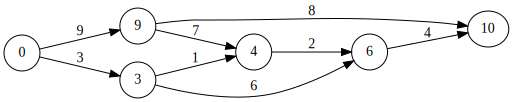

In [15]:
    draw(A, label_vector=shortest_path_length(A, 0))

# User Defined Types

In [16]:
from pygraphblas import *

class BF(Struct):
    
    members = ['double w', 'uint64_t h', 'uint64_t pi']
    identity = (lib.INFINITY, lib.UINT64_MAX, lib.UINT64_MAX)
    
    @binop(boolean=True) 
    def eq_op(z, x, y):
        if not x.w == y.w and x.h == y.h and x.pi == y.pi:
            z = True
        else:
            z = False

    @binop()
    def add_op(z, x, y):
        if (x.w < y.w 
            or x.w == y.w and x.h < y.h 
            or x.w == y.w and x.h == y.h and x.pi < y.pi):
            if (z.w != x.w and z.h != x.h and z.pi != x.pi):
                z.w = x.w
                z.h = x.h
                z.pi = x.pi        
        else:
            z.w = y.w
            z.h = y.h
            z.pi = y.pi   

    @binop()
    def mult_op(z, x, y):
        z.w = x.w + y.w
        z.h = x.h + y.h
        if x.pi != lib.UINT64_MAX and y.pi != 0:
            z.pi = y.pi
        else:
            z.pi = x.pi

In [17]:
def shortest_path(matrix, start):
    n = matrix.nrows
    v = Vector.from_type(matrix.type, n)
    for i, j, k in matrix:
        if i == j:
            matrix[i,j] = (0, 0, 0)
        else:
            matrix[i,j] = (k[0], 1, i)        
    v[start] = (0, 0, 0)
    with BF.semiring, Accum(BF.add_op):
        for _ in range(matrix.nrows):
            w = v.dup()
            v @= matrix
            if w.iseq(v):
                break
    return v

A = Matrix.from_type(BF, 6, 6)
A[0,1] = (9.0, 0, 0)
A[0,3] = (3.0, 0, 0)
A[1,2] = (8.0, 0, 0)
A[3,4] = (6.0, 0, 0)
A[3,5] = (1.0, 0, 0)
A[4,2] = (4.0, 0, 0)
A[1,5] = (7.0, 0, 0)
A[5,4] = (2.0, 0, 0)


# Materialized Shortest Path

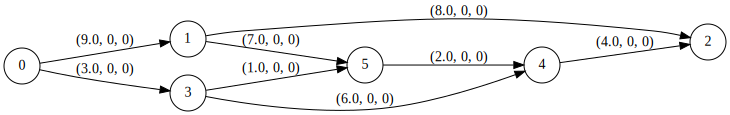

In [18]:
from pygraphblas.demo.gviz import draw
draw(A)

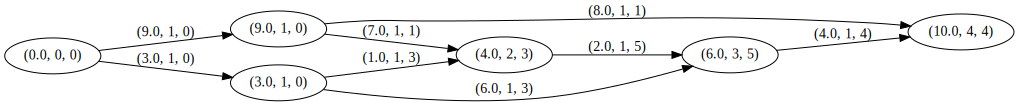

In [19]:
draw(A, label_vector=shortest_path(A, 0))

# PageRank

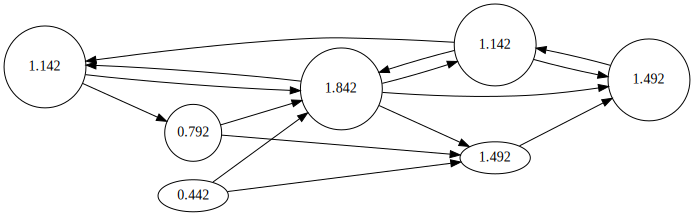

In [20]:
def pagerank(A, damping_factor, itermax):
    n = A.nrows
    d_out = A.reduce_vector()
    pr = Vector.from_type(FP32, n)
    pr[:] = 1.0/n
    teleport = (1 - damping_factor) / n
    for i in range(itermax):
        importance_vec = pr / d_out
        with Accum(times):
            importance_vec[:] = damping_factor
        importance_vec = A.transpose() @ importance_vec
        dangling_vec = pr[d_out]
        dangling_sum = dangling_vec.reduce_int() * (damping_factor / n)
        pr[:] = (teleport + dangling_sum)
        pr = pr + importance_vec
    return pr


M = Matrix.from_random(FP32, 7, 7, 30, no_diagonal=True, make_pattern=True, seed=42)

pr = pagerank(M, 0.35, 3)
draw(M, label_vector=pr, size_vector=pr, show_weight=False, label_width=5)

# Sparse Deep Neural Networks

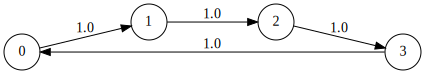

In [21]:
def permutation_matrix(size):
    P = Matrix.from_type(FP64, size, size)    
    P[size-1,0] = 1.0
    for i in range(size-1):
        P[i,i+1] = 1.0
    return P

draw_graph(permutation_matrix(4))

In [43]:
from functools import reduce
import operator

def mixed_topo_radix(topos):
    sizes = [reduce(operator.mul, x) for x in topos]
    size = sizes[0]
    layers = []
    P = permutation_matrix(size)
    
    for t in topos:
        place_value = 1
        for n in t:
            layer = Matrix.from_type(FP64, size, size)
            for j in range(n):
                layer += (P ** (j*place_value))
            place_value *= n
            layers.append(layer)      
    return layers

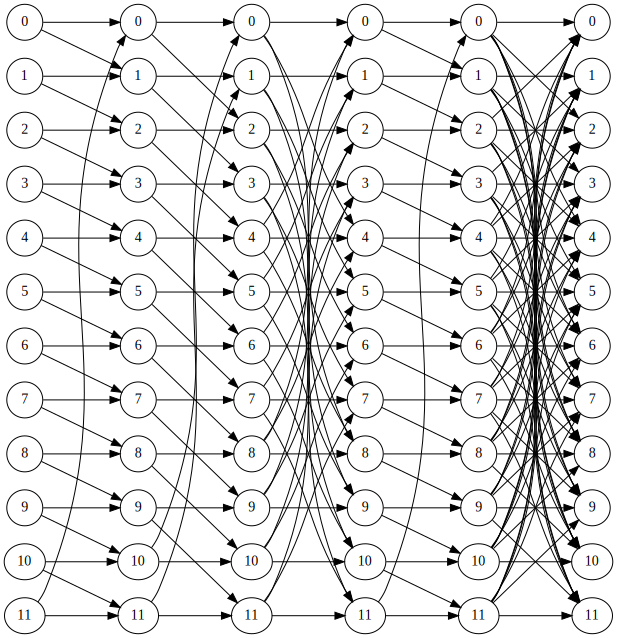

In [46]:
draw_layers(mixed_topo_radix([[2,2,3], [2,6]]))

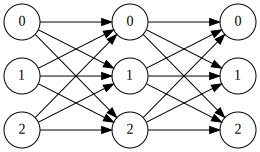

In [48]:
def ddnn(spec):
    return [Matrix.dense(FP64, spec[i], spec[i+1])
            for i in 
            range(len(spec) - 1)]

draw_layers(ddnn([3,3,3]))

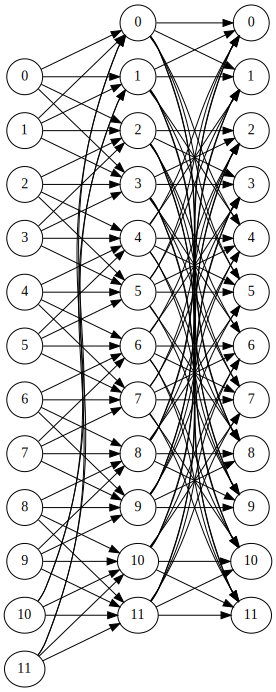

In [39]:
def radixnet(topos, spec):
    return [d.kron(w) 
            for d, w in 
            zip(mixed_topo_radix(topos), ddnn(spec))]

draw_layers(radixnet([[2,3]], [2,2,2])) 

# Forward Inference from DNN Challenge

In [49]:
def dnn(W, B, Y):
    for w, b in zip(W, B):
        Y = Y @ w
        with plus_plus:
            Y = Y @ b
        Y = Y.select('>0')
        M = Y.select('>', 32)
        if len(M):
            Y[M] = 32
    return Y